# _BEEM biomass estimation on real data_
This notebook records the code used for analyzing data from [Props _et. al._ (2016)](http://www.nature.com/ismej/journal/v11/n2/full/ismej2016117a.html). We thank the authors for providing us with the raw OTU table.

## Load required packages

In [1]:
## install BEEM
#### devtools::install_github('lch14forever/beem', dep=F)
library(beem)
library(grid)
library(ggplot2)
library(reshape2)

Loading required package: foreach
Loading required package: doMC
Loading required package: iterators
Loading required package: parallel


## Setup ggplot theme used for ploting

In [2]:
figtheme <- theme_bw() + 
  theme(text = element_text(size=15,face='bold'),panel.border  = element_rect(colour = "black",size=1.5),
        axis.title.y=element_text(margin=margin(0,8,0,0)),axis.title.x=element_text(margin=margin(8,0,0,0)),
        plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"),
        plot.title = element_text(margin=margin(0,0,8,0)))
theme_set(figtheme)

## Load data and preprosessing

In [3]:
# metadata
meta <- read.table('~/BEEM/vignettes/props_et_al_analysis/metadata.sel.txt', head =T)
meta$purterbID <- 0
# counts
df.counts <- read.table('~/BEEM/vignettes/props_et_al_analysis/counts.sel.txt', head =T,row.names=1, comment.char = "!", sep='\t')
## tss counts
df.counts.tss <- apply(df.counts, 2, function(x) x/sum(x))
## true biomass from flow cytometry
biomass.true <- read.table('~/BEEM/vignettes/props_et_al_analysis/biomass.sel.txt', head=T)$mass
## biomass calculated with metagenomeSeq (CSS)
biomass.css <- read.table('~/BEEM/vignettes/props_et_al_analysis/biomass.sel.metagenomeSeq.txt',head=T)$mass
## keep high abundant otus
fil <- apply(df.counts.tss,1,mean)>0.001
df.counts.sel <- df.counts.tss[fil,]
## biomass for selected otus
biomass.true.sel <- biomass.true*colSums(df.counts.sel)
## biomass for css biomass
biomass.css.sel <- biomass.css*colSums(df.counts.sel)
## scale counts to a defined median
scaling <- 1e5
dat <- df.counts.sel/median(colSums(df.counts.sel)) * scaling

## Run BEEM
* Note: This is time consuming and preferred to be parallelized with parameter `ncpu`.

In [4]:
res <- EM(dat=dat, meta=meta, dev=10,
          verbose=FALSE,
          refSp=NULL, 
          min_iter = 50, converge_thres = 0.001, max_iter = 100,
          ncpu=8, scaling = scaling,seed=0)

[!]: Small number (<10) of biological replicates detected. Note that BEEM works best with >10 biological replicates or the time series contains intrinsic infrequent perturbations.
The following species are not recommended due to 0 values:
Otu00013, Otu00015, Otu00017, Otu00020, Otu00021, Otu00022, Otu00023, Otu00026, Otu00043
The following species are not recommended due to their low/high abudances:
Otu00001, Otu00005, Otu00006, Otu00007, Otu00008, Otu00009, Otu00010, Otu00011, Otu00012, Otu00013, Otu00014, Otu00015, Otu00017, Otu00018, Otu00020, Otu00021, Otu00022, Otu00023, Otu00024, Otu00025, Otu00026, Otu00027, Otu00043
The following species is recommended as the reference:
Otu00003
BEEM selecting reference species as default...
Reference species: Otu00003


## Gather data for plots

In [5]:
biomass <- biomassFromEM(res, dev=0.5)

plot.dat.biomass <- data.frame("Flow cytometry"=biomass.true.sel,
                               "BEEM estimates"=biomass/scaling*median(biomass.true.sel),
                               "CSS normalized"=biomass.css.sel/median(biomass.css.sel)*median(biomass.true.sel),
                               time=meta$measurementID,
                               replicate=paste0("Replicate.",meta$subjectID))

## Biomass trajectories

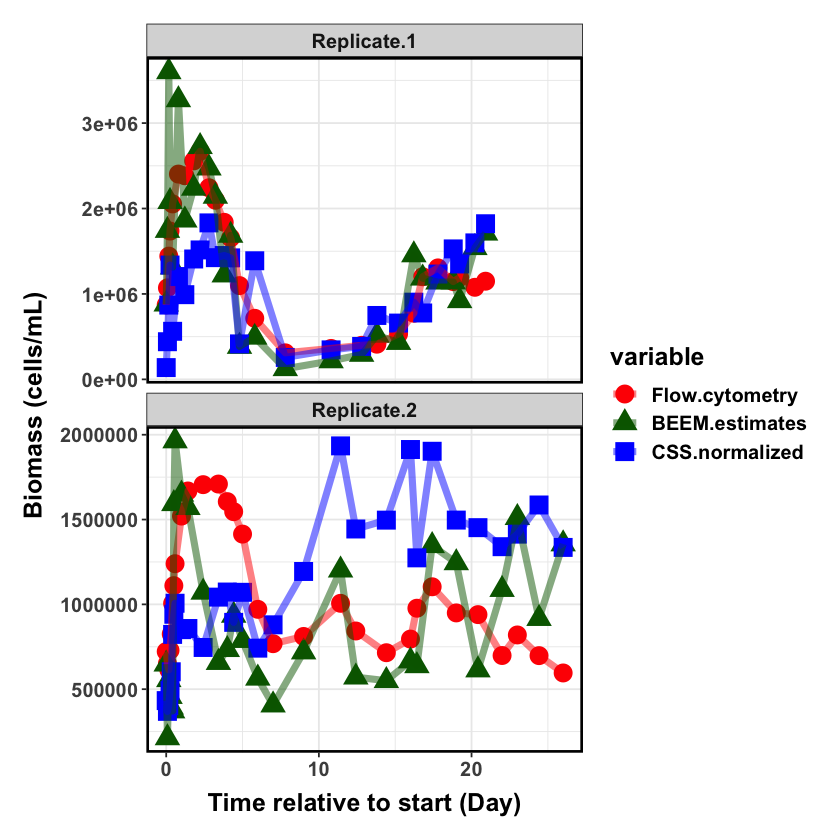

In [6]:
ggplot(melt(plot.dat.biomass, id.vars = list("time","replicate")), aes(x=time,y=value,pch=variable, col=variable)) +
    labs(x="Time relative to start (Day)",y="Biomass (cells/mL)") + 
        geom_point(size= 5) + geom_line(size=2, alpha=0.5)  + facet_wrap(~replicate,ncol=1,scale='free_y') +
            scale_color_manual(values=c('red','darkgreen','blue'))

`geom_smooth()` using formula 'y ~ x'


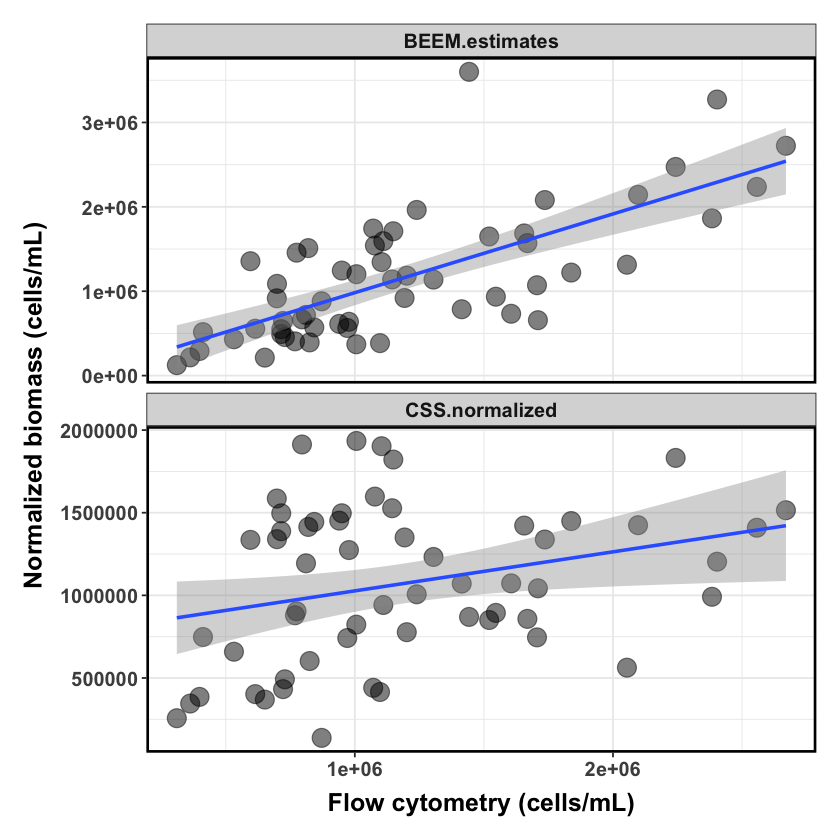

In [7]:
ggplot(melt(plot.dat.biomass, id.vars=c('time', 'replicate', 'Flow.cytometry')), 
       aes(x=Flow.cytometry, y=value)) + 
    geom_point(size=5,alpha=0.5) + 
    geom_smooth(method='lm') + 
    labs(x='Flow cytometry (cells/mL)',y='Normalized biomass (cells/mL)') +
    facet_wrap(~variable, nrow=2, scale='free_y')

In [8]:
print(cor.test(biomass.true.sel,biomass, method='spearman'))
print(cor.test(biomass.true.sel,biomass.css.sel, method='spearman'))


	Spearman's rank correlation rho

data:  biomass.true.sel and biomass
S = 8716, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7175266 


	Spearman's rank correlation rho

data:  biomass.true.sel and biomass.css.sel
S = 21606, p-value = 0.02385
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2997796 



In [9]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.15.5

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] reshape2_1.4.3   ggplot2_3.3.1    beem_0.0.0.9000  doMC_1.3.5      
[5] iterators_1.0.10 foreach_1.4.4   

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2       pillar_1.4.2     compiler_3.5.1   plyr_1.8.4      
 [5] base64enc_0.1-3  tools_3.5.1      digest_0.6.22    uuid_0.1-2      
 [9] lattice_0.20-38  nlme_3.1-137     tibble_2.1.3     jsonlite_1.6    
[13] evaluate_0.14    gtable_0.3.0     pspline_1.0-18   mgcv_1.8-26     
[17] pkgconfig_2.0.3  rlang_0.4.0 